# HEALPix Demo: Spatially Varying Photometric Errors

This notebook demonstrates how to use the CustomErrorModel with spatially varying observing conditions defined on HEALPix maps. We'll create realistic sky maps for PSF, airmass, sky brightness, and exposure time, then show how these affect photometric errors across the sky.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    import healpy as hp
except ImportError:
    print("Installing healpy...")
    !pip install healpy
    import healpy as hp

import sys
sys.path.append('..')
from photerr.custom import CustomErrorModel

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Create HEALPix Maps for Observing Conditions

First, we'll create realistic maps of observing conditions that vary across the sky:

In [2]:
def create_observing_condition_maps(nside=64):
    """Create realistic HEALPix maps for observing conditions."""
    npix = hp.nside2npix(nside)
    
    # Get pixel coordinates
    theta, phi = hp.pix2ang(nside, range(npix))
    dec = np.pi/2 - theta  # Convert to declination
    
    # Get galactic coordinates for realistic sky brightness
    gal_theta, gal_phi = hp.Rotator(coord=['C', 'G'])(theta, phi)
    gal_lat = np.pi/2 - gal_theta
    
    maps = {}
    
    # 1. PSF Maps: Worse seeing at low declination (higher airmass)
    # and some random variation for weather
    base_seeing = 0.8 + 0.4 * np.abs(np.sin(dec))**2  # 0.8" to 1.2"
    weather_noise = 0.2 * np.random.normal(0, 1, npix)
    
    for band in ['g', 'r', 'i', 'z']:
        # Wavelength-dependent seeing (better at longer wavelengths)
        wavelength_factor = {'g': 1.0, 'r': 0.95, 'i': 0.9, 'z': 0.85}[band]
        maps[f'{band}_psf'] = np.clip(
            wavelength_factor * (base_seeing + weather_noise), 0.6, 2.0
        )
    
    # 2. Airmass Maps: Function of declination with some pointing variation
    base_airmass = 1.0 / np.maximum(np.sin(dec + np.pi/4), 0.1)
    pointing_variation = 0.2 * np.random.normal(0, 1, npix)
    
    for band in ['g', 'r', 'i', 'z']:
        maps[f'{band}_airmass'] = np.clip(base_airmass + pointing_variation, 1.0, 3.0)
    
    # 3. Sky Brightness: Varies with galactic latitude and ecliptic latitude
    # Darker at high galactic latitude, brighter near galactic plane
    gal_plane_brightness = 2.0 * np.exp(-np.abs(gal_lat) / 0.3)
    
    # Zodiacal light (simplified)
    ecl_theta, ecl_phi = hp.Rotator(coord=['C', 'E'])(theta, phi)
    ecl_lat = np.pi/2 - ecl_theta
    zodiacal_light = 0.5 * np.exp(-np.abs(ecl_lat) / 0.5)
    
    # Random moon/airglow variation
    random_brightness = 0.3 * np.random.normal(0, 1, npix)
    
    # Base sky brightness by band (mag/arcsec²)
    base_sky = {'g': 22.0, 'r': 21.0, 'i': 20.0, 'z': 19.0}
    
    for band in ['g', 'r', 'i', 'z']:
        maps[f'{band}_msky'] = base_sky[band] - gal_plane_brightness - zodiacal_light + random_brightness
    
    # 4. Exposure Time: Survey strategy - more time on interesting regions
    # High galactic latitude gets more time (less crowded)
    priority_factor = 1.0 + 0.5 * np.abs(np.sin(gal_lat))
    
    # Some random variation for scheduling
    scheduling_noise = 0.3 * np.random.normal(0, 1, npix)
    
    for band in ['g', 'r', 'i', 'z']:
        base_time = {'g': 60, 'r': 60, 'i': 60, 'z': 60}[band]
        maps[f'{band}_tvis'] = np.clip(
            base_time * priority_factor * (1 + scheduling_noise), 30, 180
        )
    
    return maps, nside

# Create the maps
print("Creating observing condition maps...")
maps, nside = create_observing_condition_maps(nside=64)
print(f"Created maps with nside={nside} ({hp.nside2npix(nside)} pixels)")

Creating observing condition maps...
Created maps with nside=64 (49152 pixels)


## 2. Visualize the Input Maps

Let's visualize the observing condition maps we just created:

/var/folders/6d/cyqrs0hd3vn8xjmrq4h2rszr0000gr/T/ipykernel_21477/3900708502.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


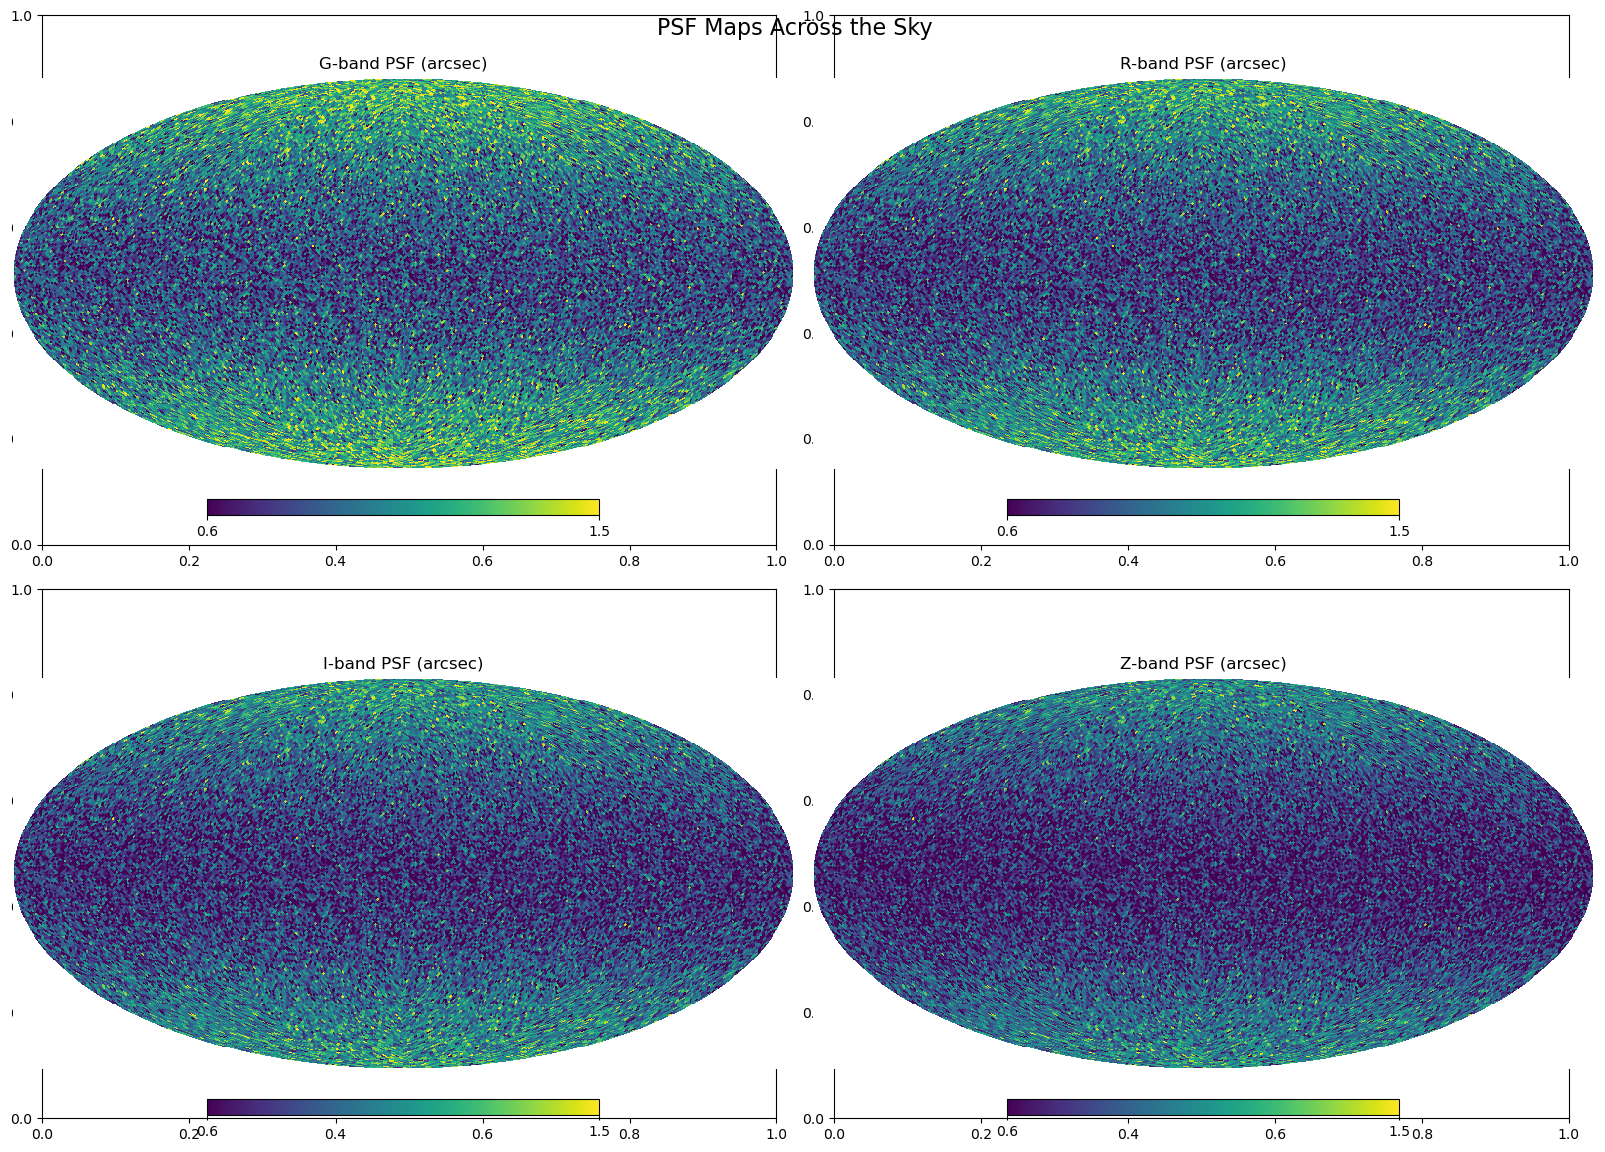

In [3]:
# Plot PSF maps
fig = plt.figure(figsize=(16, 12))
for i, band in enumerate(['g', 'r', 'i', 'z']):
    plt.subplot(2, 2, i+1)
    hp.mollview(maps[f'{band}_psf'], title=f'{band.upper()}-band PSF (arcsec)', 
                sub=(2, 2, i+1), cmap='viridis', min=0.6, max=1.5)

plt.suptitle('PSF Maps Across the Sky', fontsize=16, y=0.95)
plt.tight_layout()
plt.show()

/var/folders/6d/cyqrs0hd3vn8xjmrq4h2rszr0000gr/T/ipykernel_21477/200859746.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


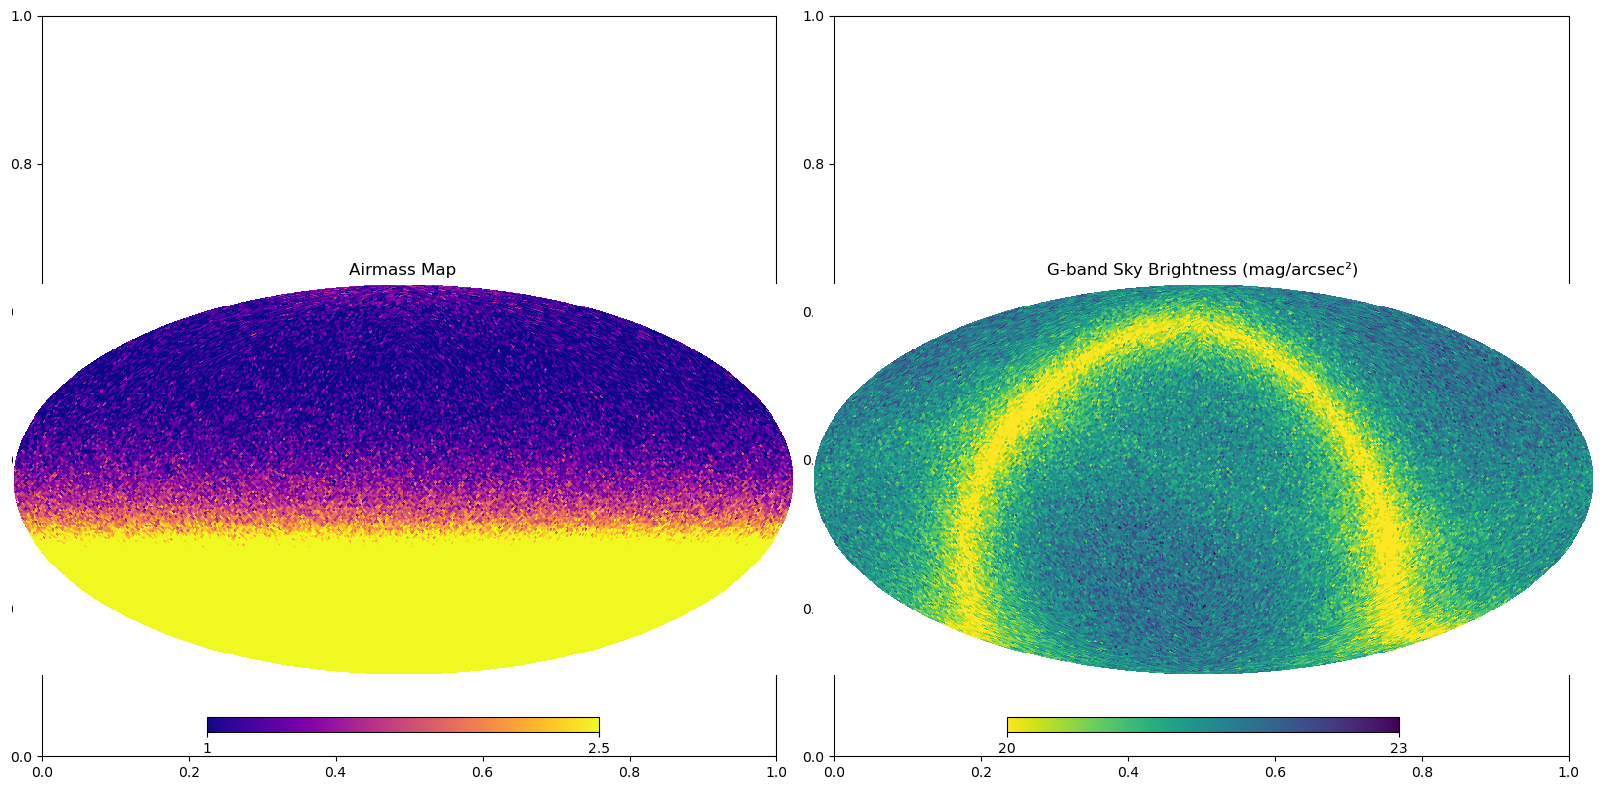

In [4]:
# Plot airmass and sky brightness
fig = plt.figure(figsize=(16, 8))

# Airmass
plt.subplot(1, 2, 1)
hp.mollview(maps['g_airmass'], title='Airmass Map', 
            sub=(1, 2, 1), cmap='plasma', min=1.0, max=2.5)

# Sky brightness (g-band)
plt.subplot(1, 2, 2)
hp.mollview(maps['g_msky'], title='G-band Sky Brightness (mag/arcsec²)', 
            sub=(1, 2, 2), cmap='viridis_r', min=20, max=23)

plt.tight_layout()
plt.show()

/var/folders/6d/cyqrs0hd3vn8xjmrq4h2rszr0000gr/T/ipykernel_21477/641403934.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


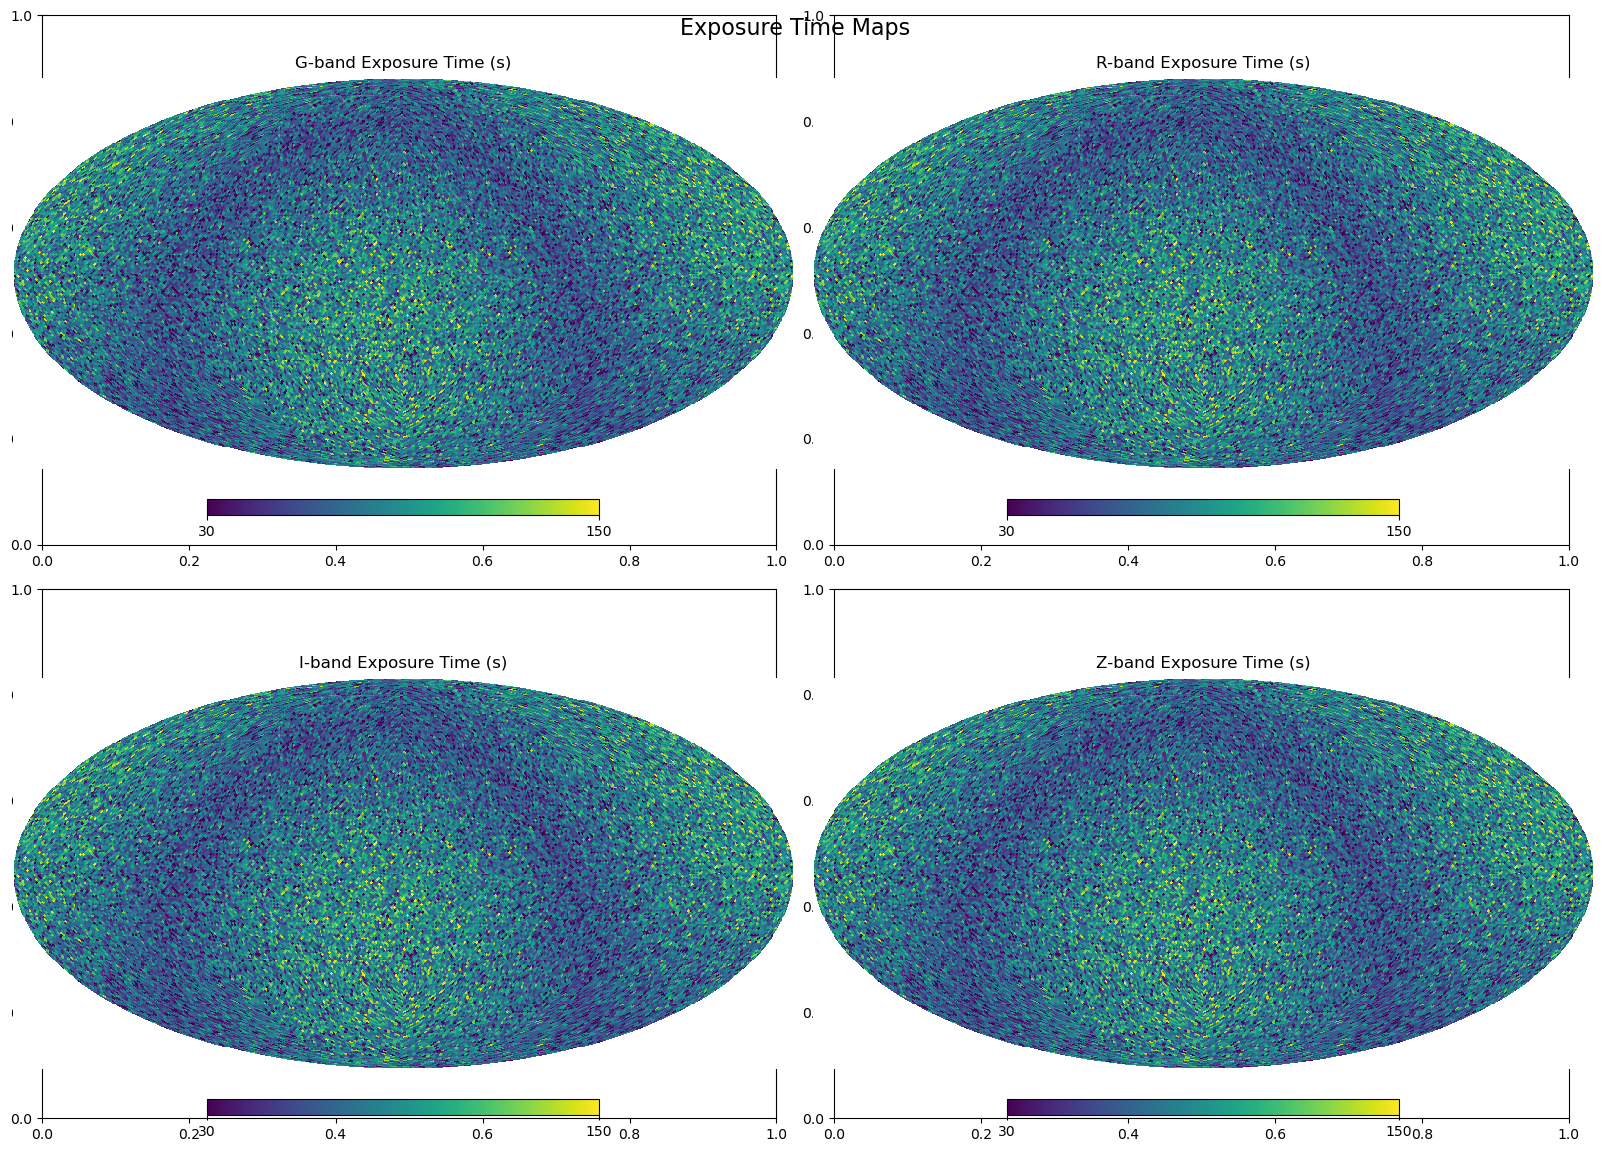

In [5]:
# Plot exposure time maps
fig = plt.figure(figsize=(16, 12))
for i, band in enumerate(['g', 'r', 'i', 'z']):
    plt.subplot(2, 2, i+1)
    hp.mollview(maps[f'{band}_tvis'], title=f'{band.upper()}-band Exposure Time (s)', 
                sub=(2, 2, i+1), cmap='viridis', min=30, max=150)

plt.suptitle('Exposure Time Maps', fontsize=16, y=0.95)
plt.tight_layout()
plt.show()

## 3. Sample Objects from the Sky

Now we'll sample objects uniformly across the sky and extract the observing conditions for each object:

In [6]:
def sample_objects_from_sky(maps, nside, n_objects=50000):
    """Sample objects uniformly across the sky."""
    # Sample positions uniformly on the sphere
    theta = np.arccos(np.random.uniform(-1, 1, n_objects))
    phi = np.random.uniform(0, 2*np.pi, n_objects)
    
    # Convert to HEALPix pixels
    pixels = hp.ang2pix(nside, theta, phi)
    
    # Convert to RA, Dec
    ra = phi * 180/np.pi
    dec = (np.pi/2 - theta) * 180/np.pi
    
    # Sample true magnitudes
    # Make them correlated (typical galaxy colors)
    g_true = np.random.uniform(20, 25, n_objects)
    r_true = g_true - 0.5 + 0.3 * np.random.normal(0, 1, n_objects)
    i_true = r_true - 0.2 + 0.2 * np.random.normal(0, 1, n_objects)
    z_true = i_true - 0.1 + 0.2 * np.random.normal(0, 1, n_objects)
    
    # Create catalog
    catalog = pd.DataFrame({
        'ra': ra,
        'dec': dec,
        'pixel': pixels,
        'g': g_true,
        'r': r_true,
        'i': i_true,
        'z': z_true
    })
    
    # Extract observing conditions from maps
    for param_name, param_map in maps.items():
        catalog[param_name] = param_map[pixels]
    
    return catalog

# Sample objects
print("Sampling objects from the sky...")
catalog = sample_objects_from_sky(maps, nside, n_objects=50000)
print(f"Sampled {len(catalog)} objects")
print("\nFirst few objects:")
print(catalog[['ra', 'dec', 'g', 'r', 'i', 'z', 'g_psf', 'g_airmass', 'g_msky', 'g_tvis']].head())

Sampling objects from the sky...
Sampled 50000 objects

First few objects:
           ra        dec          g          r          i          z  \
0  331.324505  71.401876  24.231605  23.736164  23.208760  23.026375   
1  191.944155  -0.423013  22.825935  22.646633  22.468504  22.294125   
2   50.843920  36.536888  23.453578  22.132560  21.795805  22.001445   
3  246.947982  -0.854950  22.818261  22.309124  21.737842  21.495714   
4  355.654487 -15.977010  21.630248  20.551892  20.745773  20.477981   

      g_psf  g_airmass     g_msky      g_tvis  
0  1.194136   1.171588  21.005059   55.722228  
1  0.849459   1.551678  21.525516   94.014444  
2  0.868381   1.000000  21.229436   89.748501  
3  1.055512   1.683124  21.124145  100.731609  
4  0.773337   1.998644  21.420447  116.693134  


## 4. Apply the Error Model

Now we'll apply the CustomErrorModel to get observed magnitudes with realistic errors:

In [7]:
# Apply the custom error model
print("Applying CustomErrorModel with spatially varying parameters...")
err_model = CustomErrorModel()
catalog_with_errors = err_model(catalog, random_state=42)

print("\nError statistics:")
error_cols = ['g_err', 'r_err', 'i_err', 'z_err']
print(catalog_with_errors[error_cols].describe())

Applying CustomErrorModel with spatially varying parameters...

Error statistics:
              g_err         r_err         i_err         z_err
count  50000.000000  50000.000000  50000.000000  5.000000e+04
mean       0.016585      0.010077      0.013542           inf
std        0.019480      0.009839      0.015856           NaN
min        0.005004      0.005001      0.005001  5.005409e-03
25%        0.005360      0.005086      0.005192  6.225636e-03
50%        0.007885      0.005823      0.006704  1.278904e-02
75%        0.019808      0.010706      0.015087  3.755628e-02
max        0.296645      0.182625      0.380747           inf


## 5. Create Maps of Results

Now let's create HEALPix maps showing the observed magnitudes and errors:

In [8]:
def create_result_maps(catalog_with_errors, nside):
    """Create HEALPix maps from the catalog results."""
    npix = hp.nside2npix(nside)
    
    # Initialize maps with NaN
    result_maps = {}
    
    columns_to_map = ['g', 'r', 'i', 'z', 'g_err', 'r_err', 'i_err', 'z_err']
    
    for col in columns_to_map:
        result_maps[col] = np.full(npix, hp.UNSEEN)
    
    # Fill in the maps where we have data
    pixels = catalog_with_errors['pixel'].values
    
    for col in columns_to_map:
        # Average values for pixels with multiple objects
        for pixel in np.unique(pixels):
            mask = pixels == pixel
            if np.any(mask):
                result_maps[col][pixel] = np.mean(catalog_with_errors[col][mask])
    
    return result_maps

# Create result maps
print("Creating result maps...")
result_maps = create_result_maps(catalog_with_errors, nside)

Creating result maps...


## 6. Visualize the Results

Let's visualize the observed magnitudes and errors on the sky:

/var/folders/6d/cyqrs0hd3vn8xjmrq4h2rszr0000gr/T/ipykernel_21477/1974174461.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


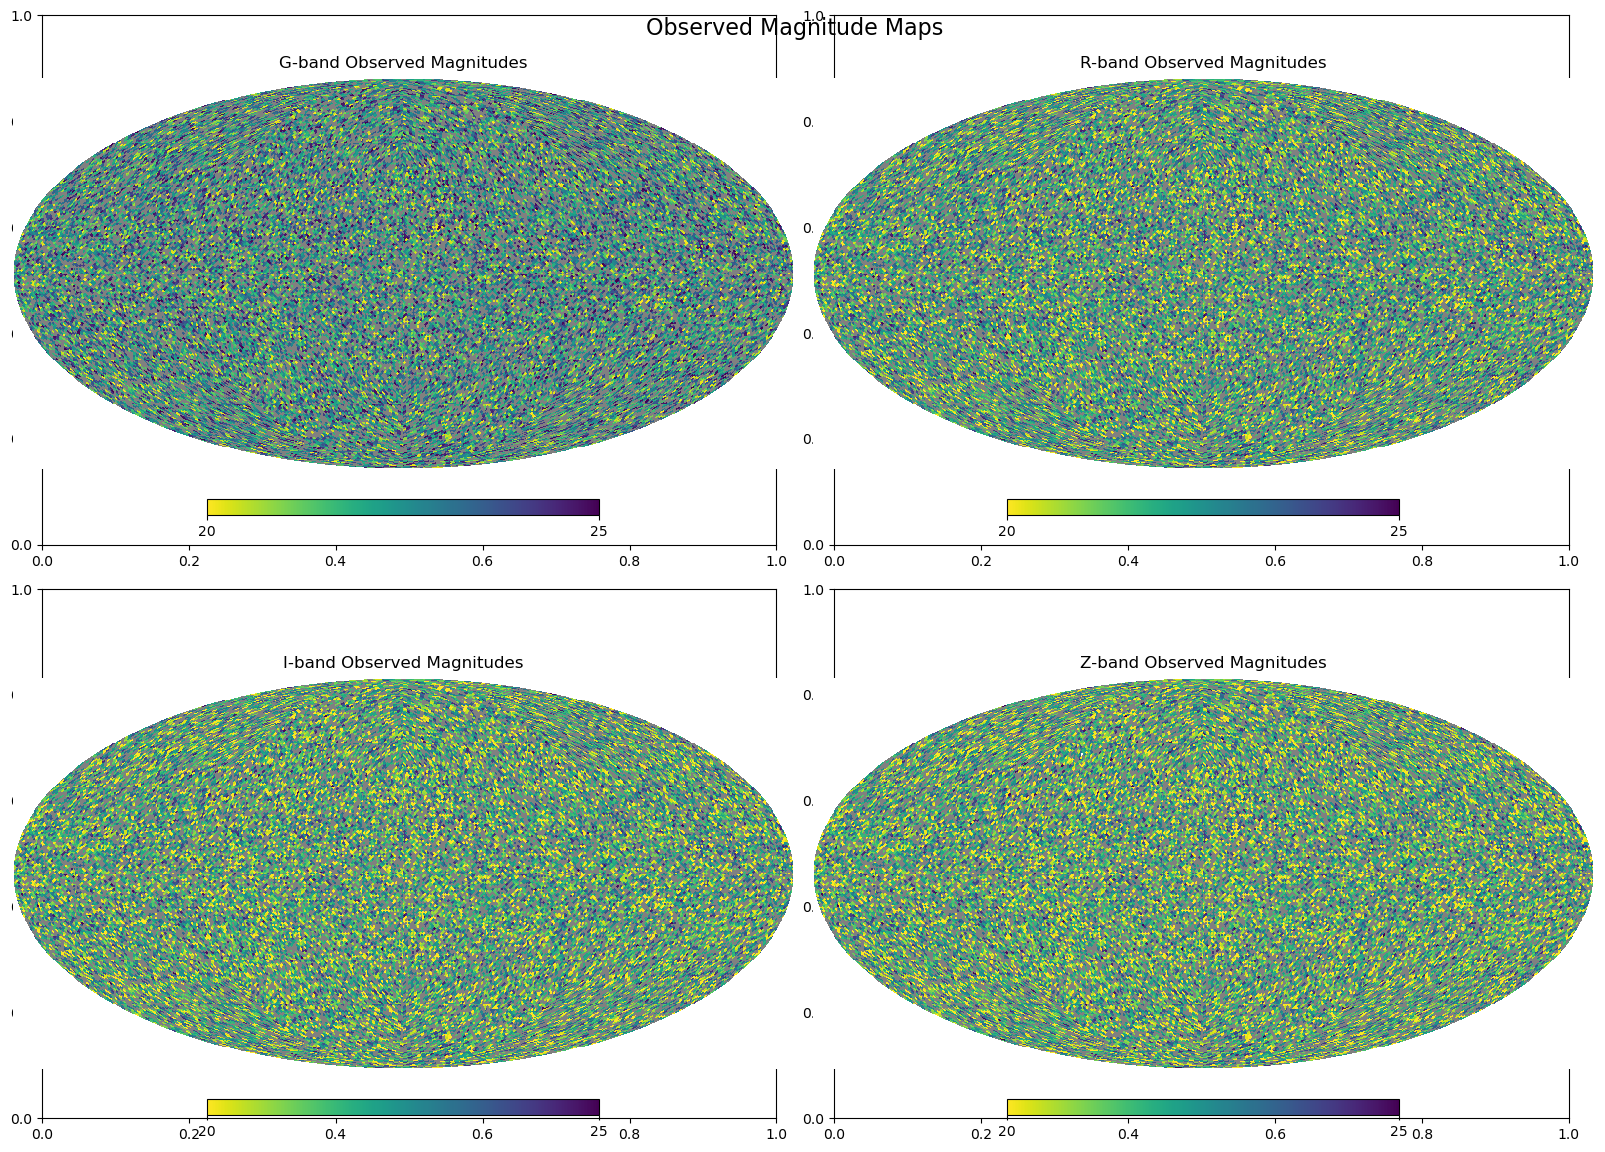

In [9]:
# Plot observed magnitude maps
fig = plt.figure(figsize=(16, 12))
for i, band in enumerate(['g', 'r', 'i', 'z']):
    plt.subplot(2, 2, i+1)
    hp.mollview(result_maps[band], title=f'{band.upper()}-band Observed Magnitudes', 
                sub=(2, 2, i+1), cmap='viridis_r', min=20, max=25)

plt.suptitle('Observed Magnitude Maps', fontsize=16, y=0.95)
plt.tight_layout()
plt.show()

/var/folders/6d/cyqrs0hd3vn8xjmrq4h2rszr0000gr/T/ipykernel_21477/3887745206.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


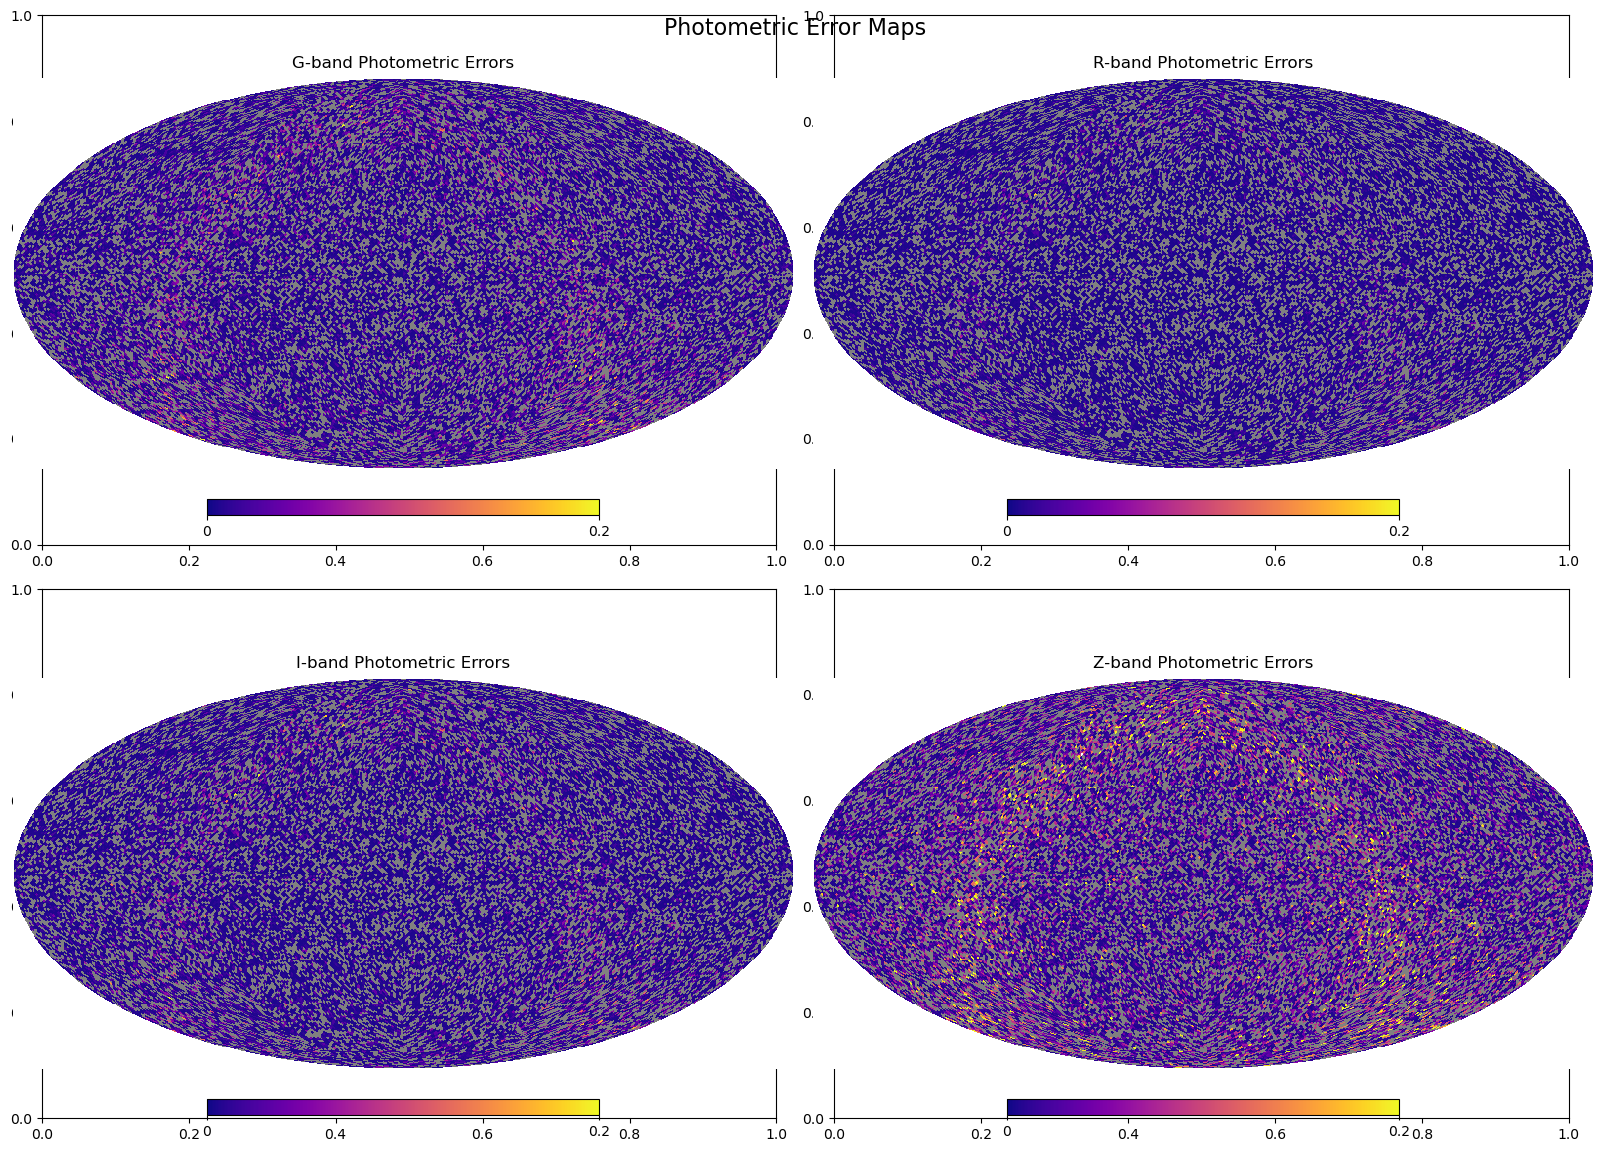

In [10]:
# Plot photometric error maps
fig = plt.figure(figsize=(16, 12))
for i, band in enumerate(['g', 'r', 'i', 'z']):
    plt.subplot(2, 2, i+1)
    hp.mollview(result_maps[f'{band}_err'], title=f'{band.upper()}-band Photometric Errors', 
                sub=(2, 2, i+1), cmap='plasma', min=0, max=0.2)

plt.suptitle('Photometric Error Maps', fontsize=16, y=0.95)
plt.tight_layout()
plt.show()

## 7. Compare with Constant Conditions

Let's compare the results with what we'd get from constant observing conditions:

Comparison of error distributions:

Variable conditions:
              g_err         r_err         i_err         z_err
count  50000.000000  50000.000000  50000.000000  5.000000e+04
mean       0.016585      0.010077      0.013542           inf
std        0.019480      0.009839      0.015856           NaN
min        0.005004      0.005001      0.005001  5.005409e-03
25%        0.005360      0.005086      0.005192  6.225636e-03
50%        0.007885      0.005823      0.006704  1.278904e-02
75%        0.019808      0.010706      0.015087  3.755628e-02
max        0.296645      0.182625      0.380747           inf

Constant conditions:
              g_err         r_err         i_err         z_err
count  50000.000000  50000.000000  50000.000000  50000.000000
mean       0.012362      0.007953      0.009842      0.022034
std        0.010499      0.004968      0.007981      0.025554
min        0.005022      0.005001      0.005001      0.005009
25%        0.005220      0.005050      0.005100      

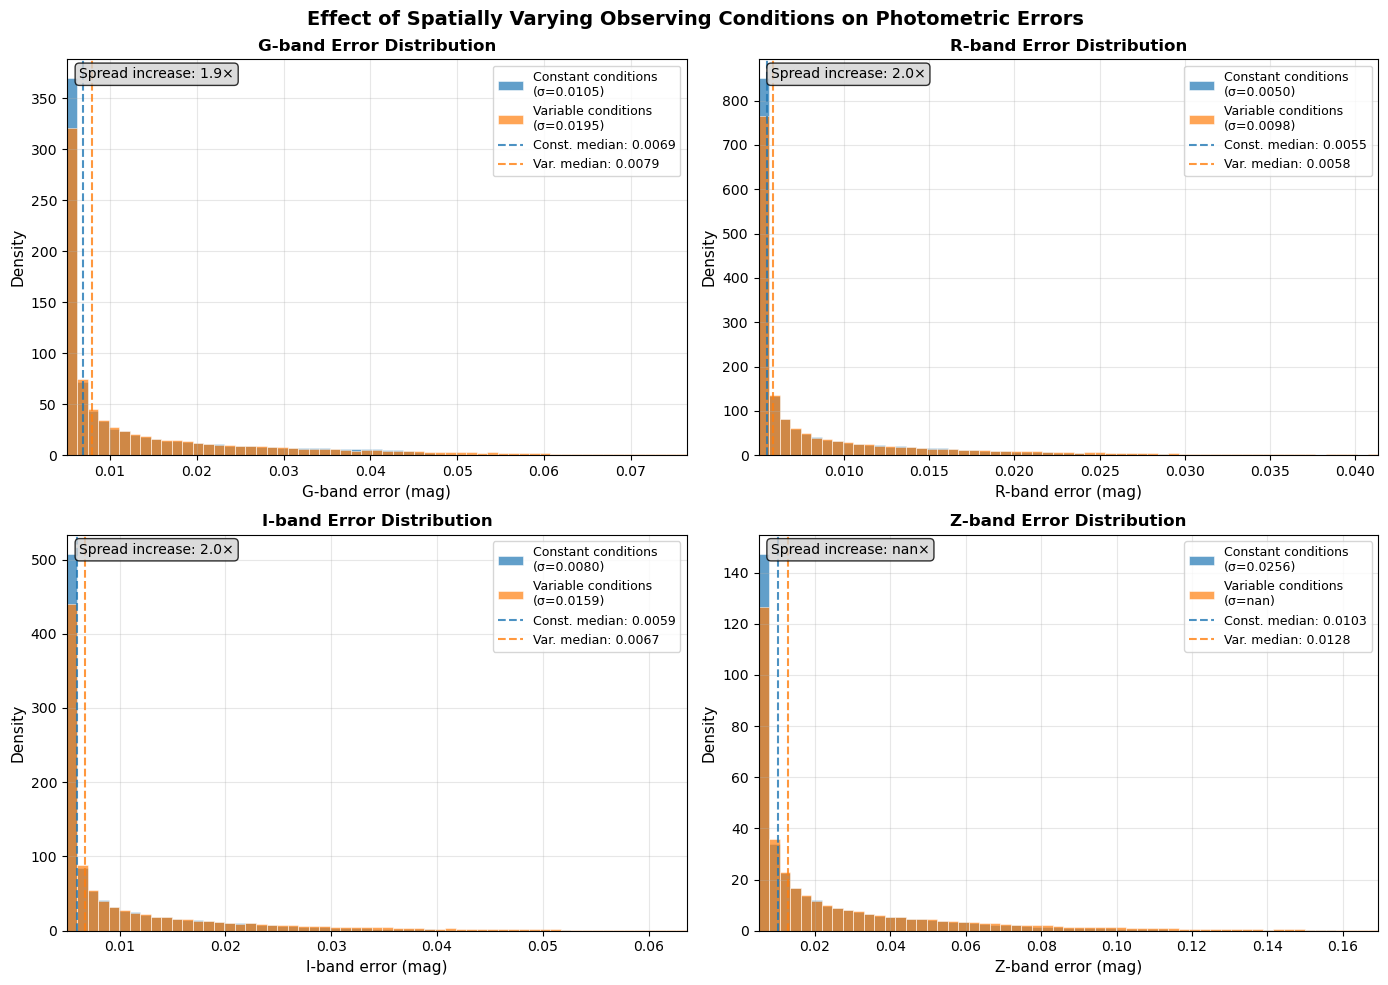


Quantitative impact of spatial variation:
Band | Constant σ | Variable σ | Ratio | Constant 95% | Variable 95%
-----------------------------------------------------------------
   G |    0.0105 |    0.0195 | 1.86 |      0.0373 |      0.0551
   R |    0.0050 |    0.0098 | 1.98 |      0.0191 |      0.0287
   I |    0.0080 |    0.0159 | 1.99 |      0.0272 |      0.0437
   Z |    0.0256 |       nan |  nan |      0.0757 |      0.1135


In [11]:
# Create catalog with constant conditions (no per-object parameters)
catalog_const = catalog[['ra', 'dec', 'pixel', 'g', 'r', 'i', 'z']].copy()
catalog_const_errors = err_model(catalog_const, random_state=42)

print("Comparison of error distributions:")
print("\nVariable conditions:")
print(catalog_with_errors[error_cols].describe())
print("\nConstant conditions:")
print(catalog_const_errors[error_cols].describe())

# Calculate statistics for better visualization
print("\nDetailed comparison:")
for band in ['g', 'r', 'i', 'z']:
    err_col = f'{band}_err'
    var_std = catalog_with_errors[err_col].std()
    const_std = catalog_const_errors[err_col].std()
    var_mean = catalog_with_errors[err_col].mean()
    const_mean = catalog_const_errors[err_col].mean()
    print(f"{band.upper()}-band: Variable std={var_std:.4f}, Constant std={const_std:.4f}, "
          f"ratio={var_std/const_std:.2f}")

# Improved plot comparison with better styling
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Define colors for consistency
color_const = '#1f77b4'  # Blue
color_var = '#ff7f0e'    # Orange

for i, band in enumerate(['g', 'r', 'i', 'z']):
    err_col = f'{band}_err'
    
    # Calculate appropriate bin range
    all_errors = np.concatenate([catalog_const_errors[err_col], catalog_with_errors[err_col]])
    min_err, max_err = np.percentile(all_errors, [1, 99])
    bins = np.linspace(min_err, max_err, 60)
    
    # Create histograms with better styling
    axes[i].hist(catalog_const_errors[err_col], bins=bins, alpha=0.7, 
                label=f'Constant conditions\n(σ={catalog_const_errors[err_col].std():.4f})', 
                density=True, color=color_const, edgecolor='white', linewidth=0.5)
    axes[i].hist(catalog_with_errors[err_col], bins=bins, alpha=0.7, 
                label=f'Variable conditions\n(σ={catalog_with_errors[err_col].std():.4f})', 
                density=True, color=color_var, edgecolor='white', linewidth=0.5)
    
    # Add median lines
    const_median = np.median(catalog_const_errors[err_col])
    var_median = np.median(catalog_with_errors[err_col])
    axes[i].axvline(const_median, color=color_const, linestyle='--', alpha=0.8, 
                   label=f'Const. median: {const_median:.4f}')
    axes[i].axvline(var_median, color=color_var, linestyle='--', alpha=0.8,
                   label=f'Var. median: {var_median:.4f}')
    
    # Styling
    axes[i].set_xlabel(f'{band.upper()}-band error (mag)', fontsize=11)
    axes[i].set_ylabel('Density', fontsize=11)
    axes[i].set_title(f'{band.upper()}-band Error Distribution', fontsize=12, fontweight='bold')
    axes[i].legend(fontsize=9, loc='upper right')
    axes[i].grid(True, alpha=0.3)
    axes[i].set_xlim(min_err, max_err)
    
    # Add text box with statistics
    improvement_factor = catalog_with_errors[err_col].std() / catalog_const_errors[err_col].std()
    textstr = f'Spread increase: {improvement_factor:.1f}×'
    props = dict(boxstyle='round', facecolor='lightgray', alpha=0.8)
    axes[i].text(0.02, 0.98, textstr, transform=axes[i].transAxes, fontsize=10,
                verticalalignment='top', bbox=props)

plt.suptitle('Effect of Spatially Varying Observing Conditions on Photometric Errors', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print quantitative comparison
print("\nQuantitative impact of spatial variation:")
print("Band | Constant σ | Variable σ | Ratio | Constant 95% | Variable 95%")
print("-" * 65)
for band in ['g', 'r', 'i', 'z']:
    err_col = f'{band}_err'
    const_std = catalog_const_errors[err_col].std()
    var_std = catalog_with_errors[err_col].std()
    const_95 = np.percentile(catalog_const_errors[err_col], 95)
    var_95 = np.percentile(catalog_with_errors[err_col], 95)
    ratio = var_std / const_std
    print(f"{band.upper():>4} | {const_std:>9.4f} | {var_std:>9.4f} | {ratio:>4.2f} | {const_95:>11.4f} | {var_95:>11.4f}")

## 8. Analyze Correlations

Let's analyze how the observing conditions correlate with the photometric errors:

Correlation between observing conditions and G-band errors:
  g_psf: 0.176
  g_airmass: 0.102
  g_msky: -0.259
  g_tvis: -0.181


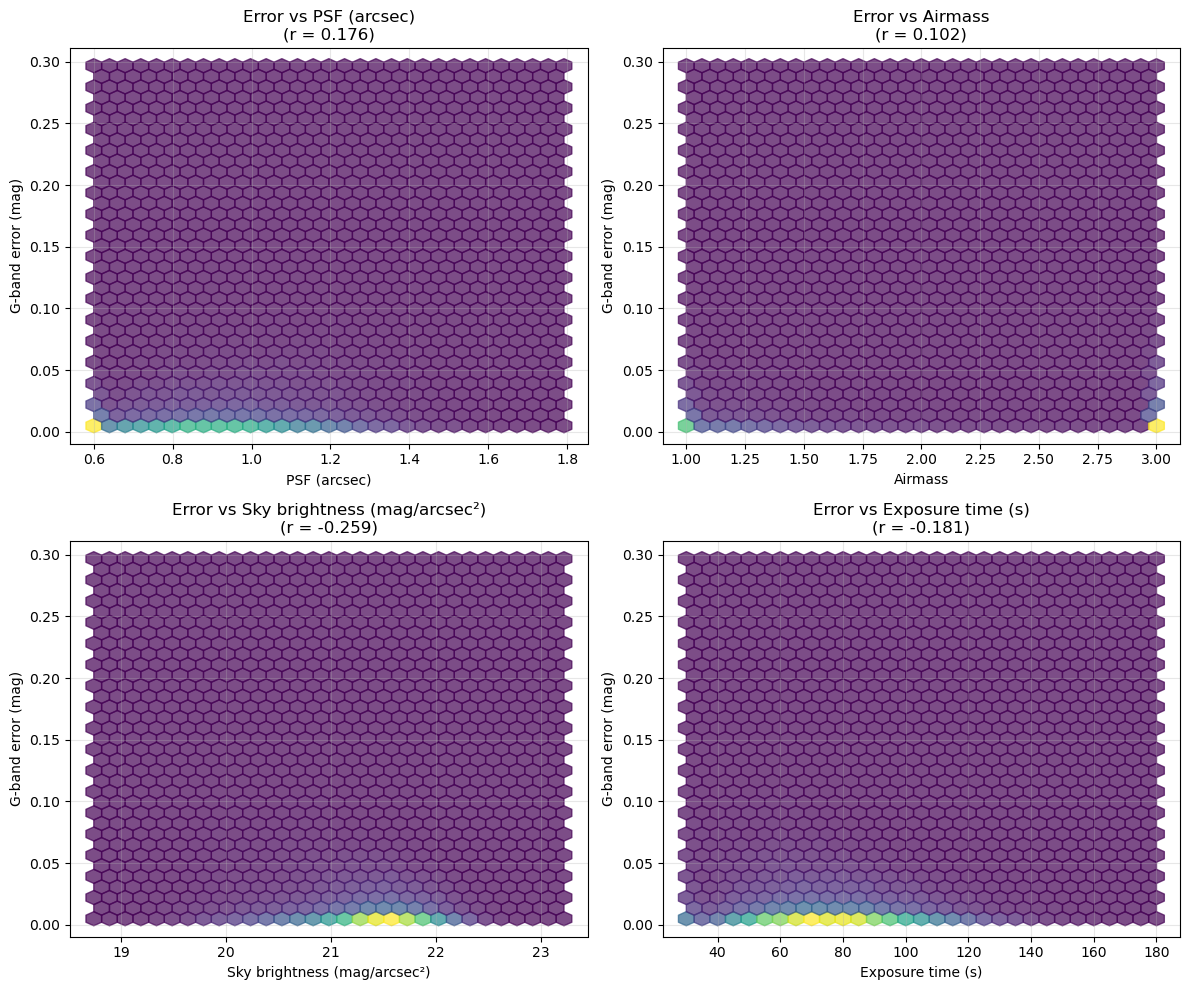

In [12]:
# Calculate correlations
print("Correlation between observing conditions and G-band errors:")
obs_params = ['g_psf', 'g_airmass', 'g_msky', 'g_tvis']
correlations = {}

for param in obs_params:
    corr = np.corrcoef(catalog_with_errors[param], catalog_with_errors['g_err'])[0, 1]
    correlations[param] = corr
    print(f"  {param}: {corr:.3f}")

# Plot correlations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

param_labels = ['PSF (arcsec)', 'Airmass', 'Sky brightness (mag/arcsec²)', 'Exposure time (s)']

for i, (param, label) in enumerate(zip(obs_params, param_labels)):
    # Create 2D histogram for cleaner visualization
    axes[i].hexbin(catalog_with_errors[param], catalog_with_errors['g_err'], 
                   gridsize=30, cmap='viridis', alpha=0.7)
    axes[i].set_xlabel(label)
    axes[i].set_ylabel('G-band error (mag)')
    axes[i].set_title(f'Error vs {label}\n(r = {correlations[param]:.3f})')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Show Error vs Magnitude Relationships

Finally, let's show how the errors vary with magnitude in different regions of the sky:

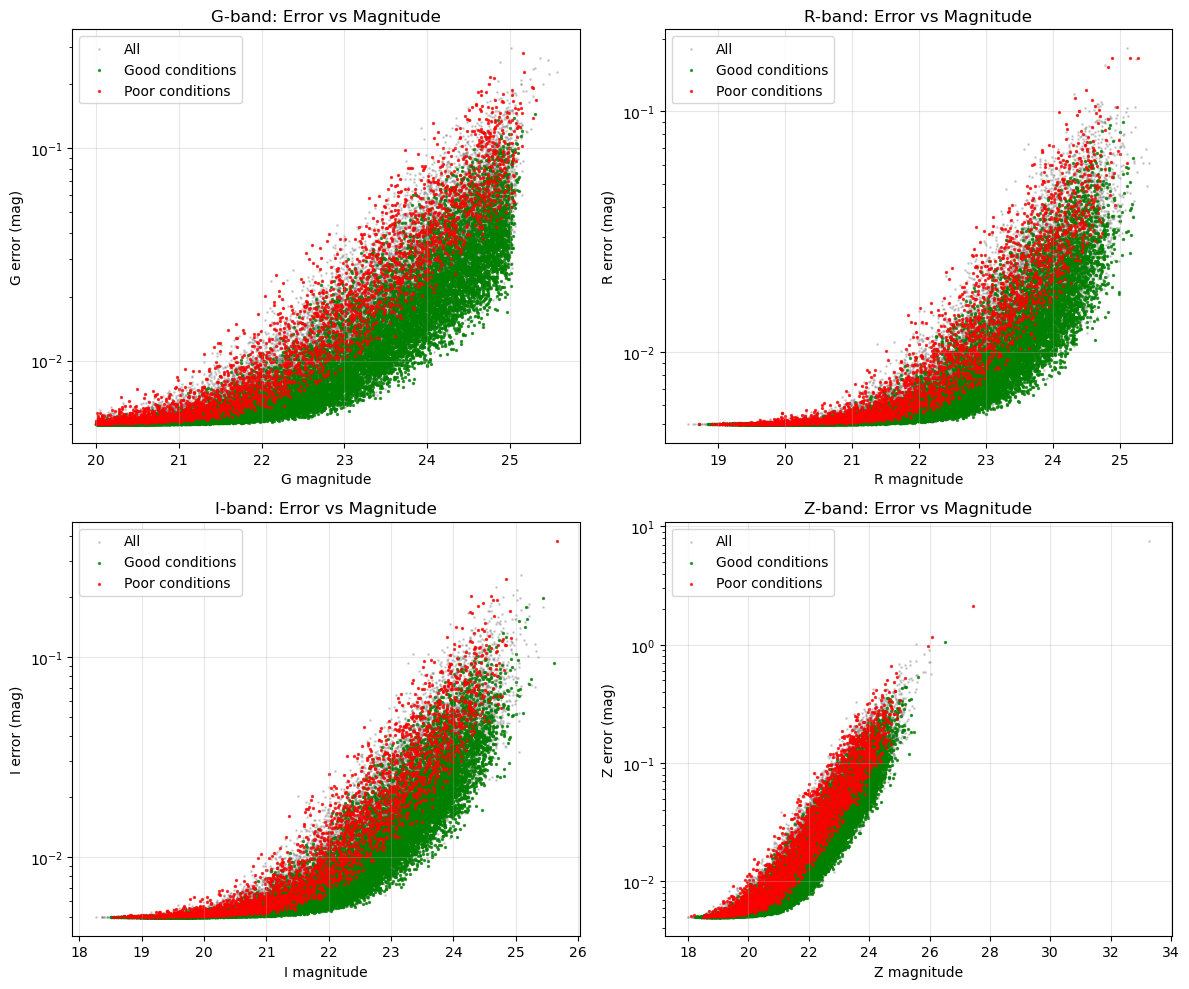

Good conditions: 16170 objects
Poor conditions: 3128 objects
Total objects: 50000


In [13]:
# Divide sky into regions based on observing conditions
# Good conditions: low PSF, low airmass
good_conditions = ((catalog_with_errors['g_psf'] < 1.0) & 
                   (catalog_with_errors['g_airmass'] < 1.5))

# Poor conditions: high PSF, high airmass
poor_conditions = ((catalog_with_errors['g_psf'] > 1.2) & 
                   (catalog_with_errors['g_airmass'] > 1.8))

# Plot error vs magnitude for different conditions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, band in enumerate(['g', 'r', 'i', 'z']):
    err_col = f'{band}_err'
    
    # Plot all points
    axes[i].scatter(catalog_with_errors[band], catalog_with_errors[err_col], 
                   alpha=0.3, s=1, color='gray', label='All')
    
    # Highlight good conditions
    if np.any(good_conditions):
        axes[i].scatter(catalog_with_errors[band][good_conditions], 
                       catalog_with_errors[err_col][good_conditions], 
                       alpha=0.7, s=2, color='green', label='Good conditions')
    
    # Highlight poor conditions
    if np.any(poor_conditions):
        axes[i].scatter(catalog_with_errors[band][poor_conditions], 
                       catalog_with_errors[err_col][poor_conditions], 
                       alpha=0.7, s=2, color='red', label='Poor conditions')
    
    axes[i].set_xlabel(f'{band.upper()} magnitude')
    axes[i].set_ylabel(f'{band.upper()} error (mag)')
    axes[i].set_title(f'{band.upper()}-band: Error vs Magnitude')
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()
    axes[i].set_yscale('log')

plt.tight_layout()
plt.show()

print(f"Good conditions: {np.sum(good_conditions)} objects")
print(f"Poor conditions: {np.sum(poor_conditions)} objects")
print(f"Total objects: {len(catalog_with_errors)}")

## Summary

This notebook demonstrated:

1. **Creating realistic HEALPix maps** of observing conditions (PSF, airmass, sky brightness, exposure time)
2. **Sampling objects** uniformly across the sky and extracting per-object parameters
3. **Applying the CustomErrorModel** with spatially varying parameters
4. **Visualizing results** on HEALPix maps showing observed magnitudes and errors
5. **Comparing with constant conditions** to show the effect of spatial variation
6. **Analyzing correlations** between observing conditions and photometric errors

Key findings:
- Spatially varying conditions significantly broaden the error distribution
- PSF and airmass are positively correlated with errors (as expected)
- Sky brightness and exposure time show the expected negative correlation with errors
- Error patterns on the sky reflect the underlying observing condition maps

The CustomErrorModel successfully handles per-object parameters from HEALPix maps, making it suitable for realistic wide-field survey simulations.